In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

2021-09-12 21:09:57.191831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-12 21:09:57.191854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data, test = data.select_dtypes(include=np.number), test.select_dtypes(include=np.number) # Take only numeric columns
data, test = data.dropna(), test.dropna() # Drop rows with null values
data.pop('Id') # Pop id column
test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,506.0,0,82,0,0,144,0,0,1,2010


array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>],
       [<AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>],
       [<AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>],
       [<AxesSubplot:title={'center':'Ful

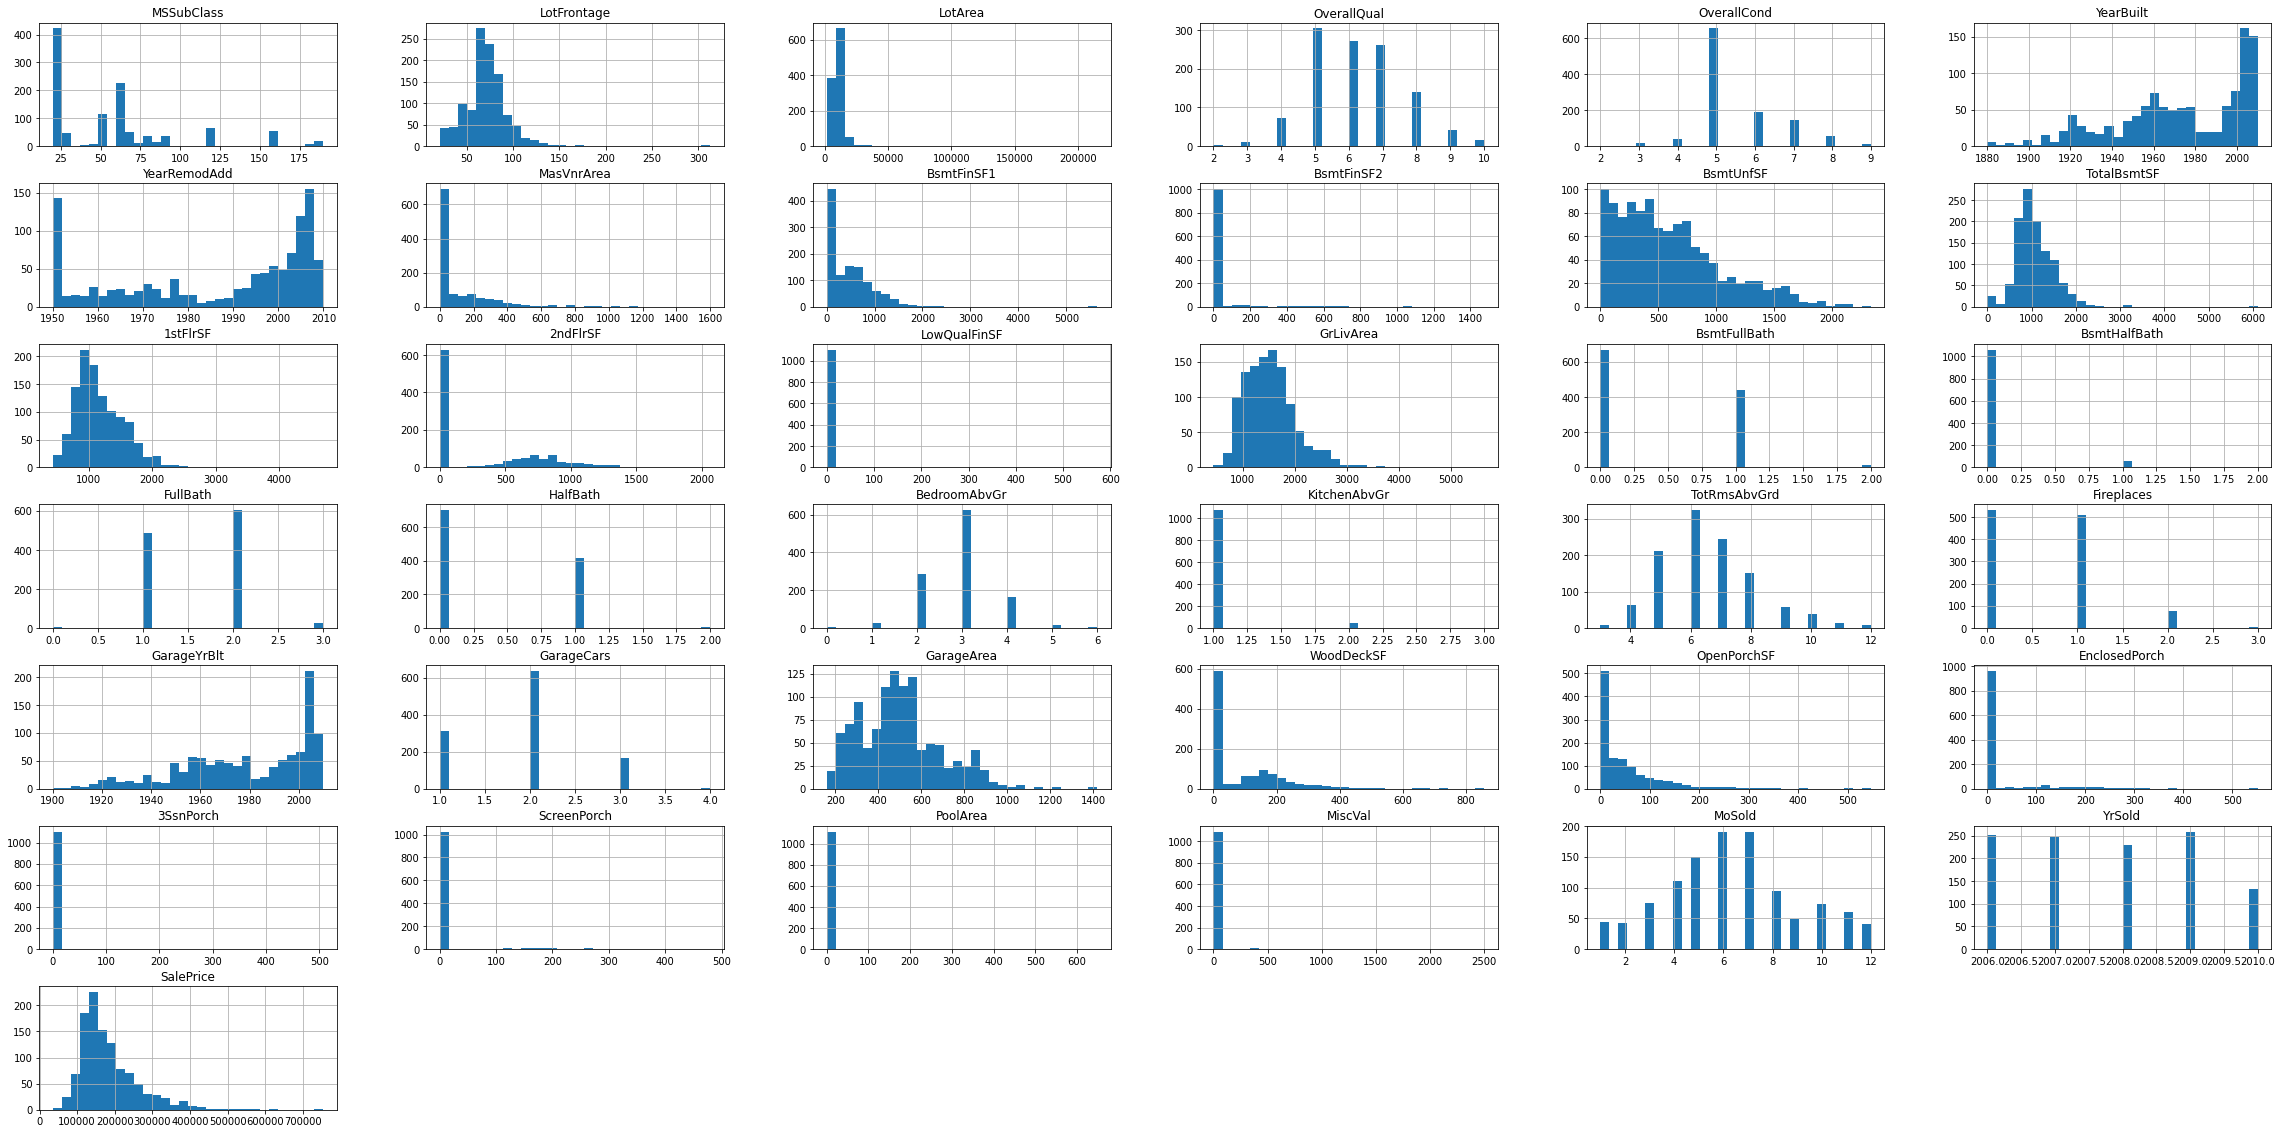

In [4]:
data.hist(figsize=(40,20), bins=30)

<AxesSubplot:>

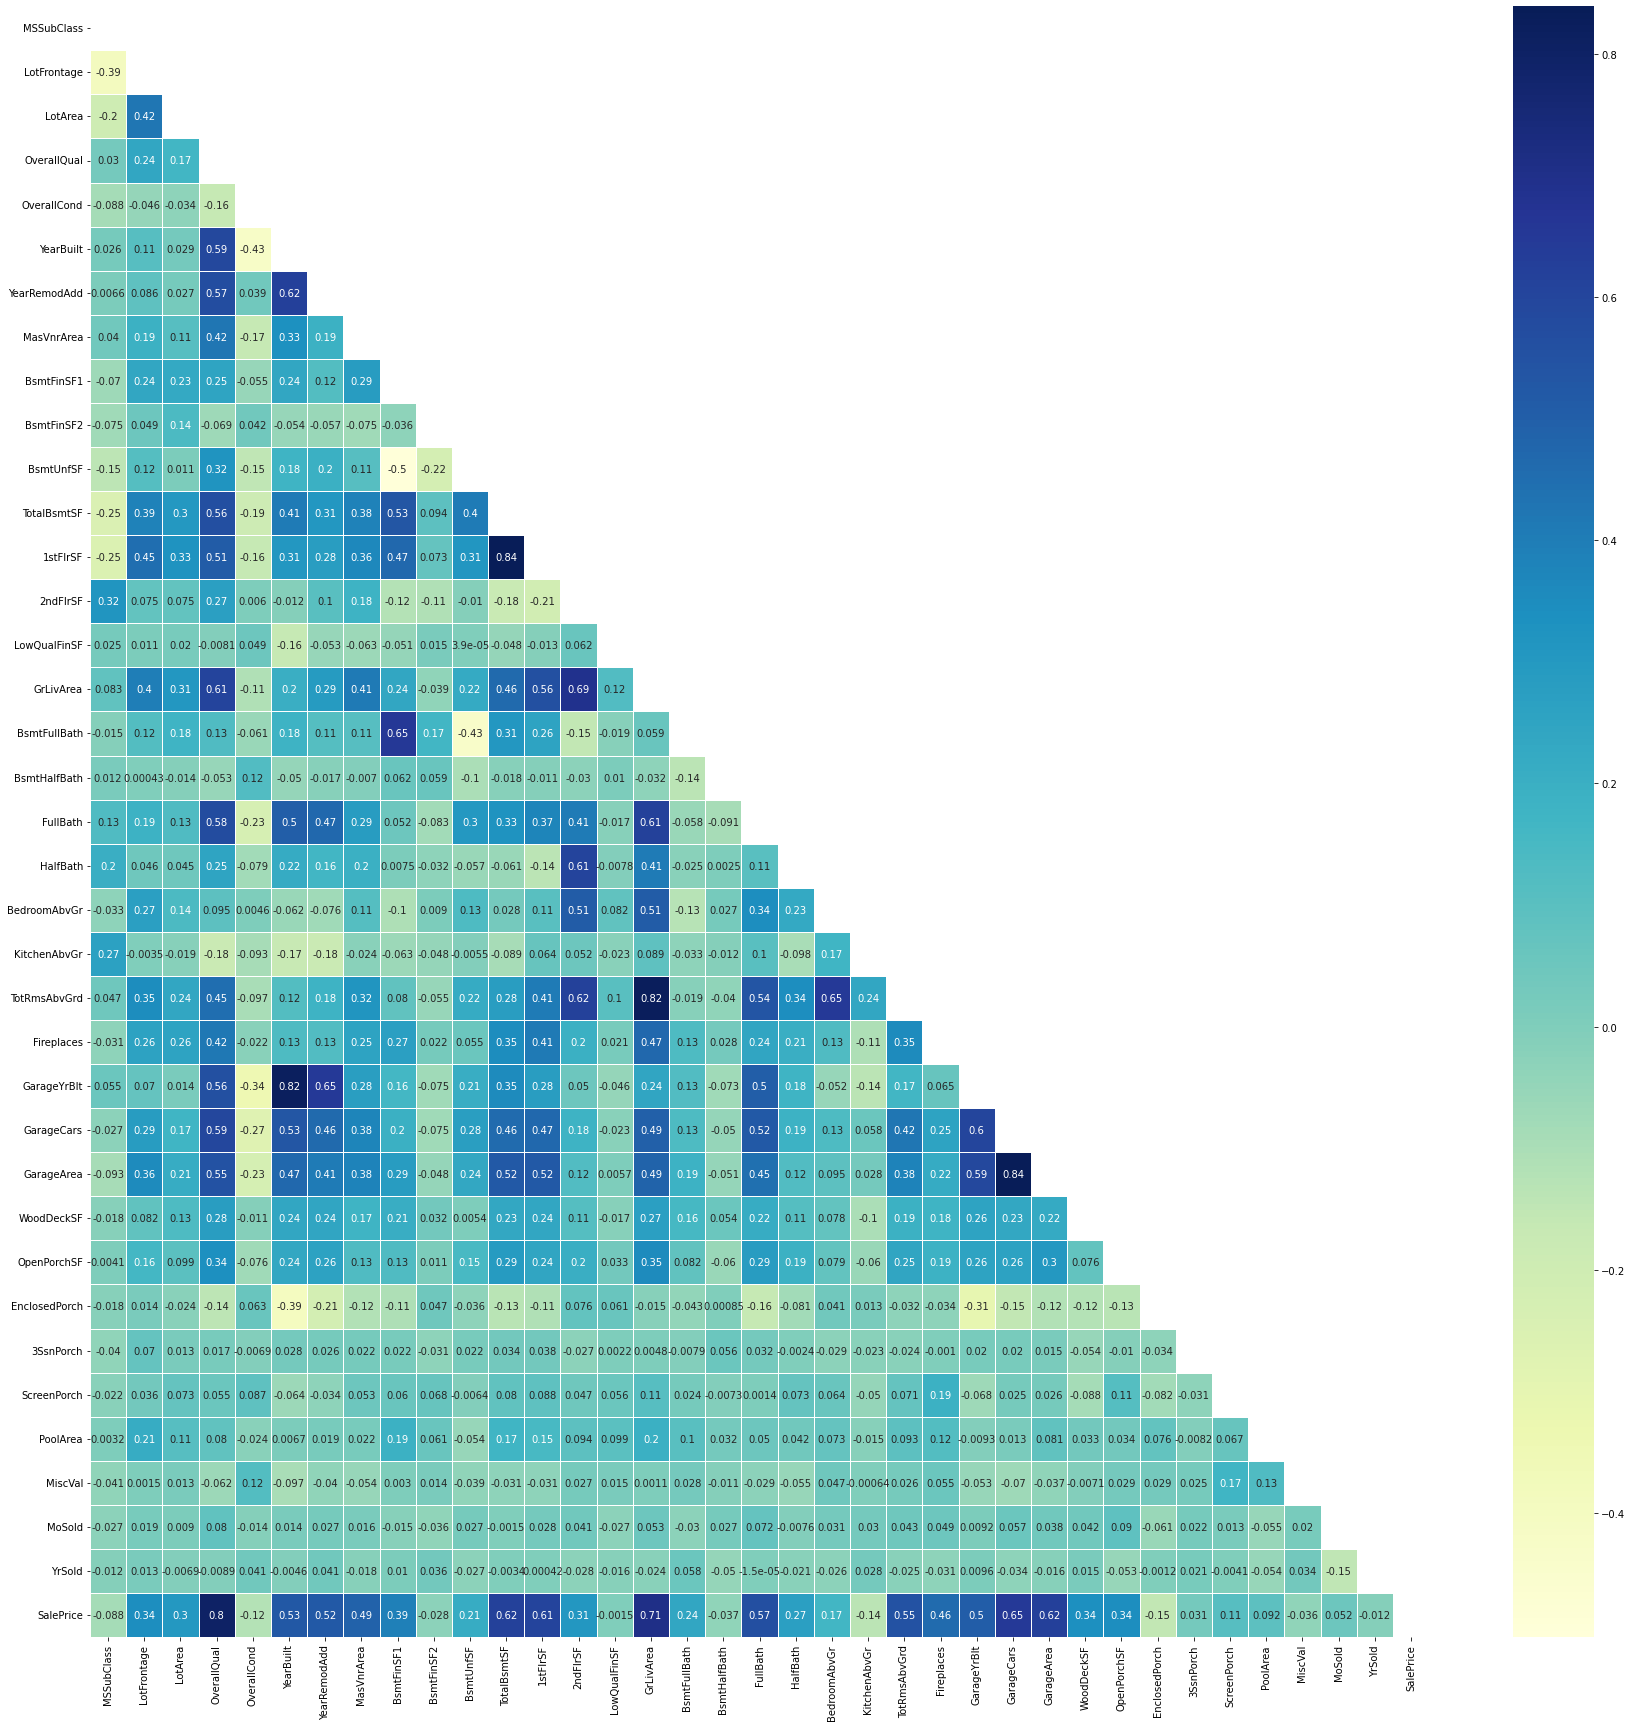

In [5]:
plt.figure(figsize=(30, 30))
sns.heatmap(data.corr(), annot=True, linewidth=.8, mask=np.triu(data.corr()), cmap="YlGnBu")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.2, random_state=0)
x_train, x_test, y_train, y_test = x_train.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
x_train.shape, x_test.shape, y_train.shape, y_test.shape, test.shape

((896, 36), (225, 36), (896,), (225,), (1146, 37))

In [7]:
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.05)
xgb.fit(x_train, y_train)

SVR_ = SVR()
SVR_.fit(x_train, y_train)

model = Sequential()
model.add(Input(shape=[len(x_train[0])]))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(), metrics=['mae', 'mse'])
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=0)


2021-09-12 21:10:10.303694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 21:10:10.304157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-12 21:10:10.304206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-12 21:10:10.304251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-09-12 21:10:10.304293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
svr_pred = SVR_.predict(x_test)
xbg_pred = xgb.predict(x_test)
nn_pred = model.predict(x_test)

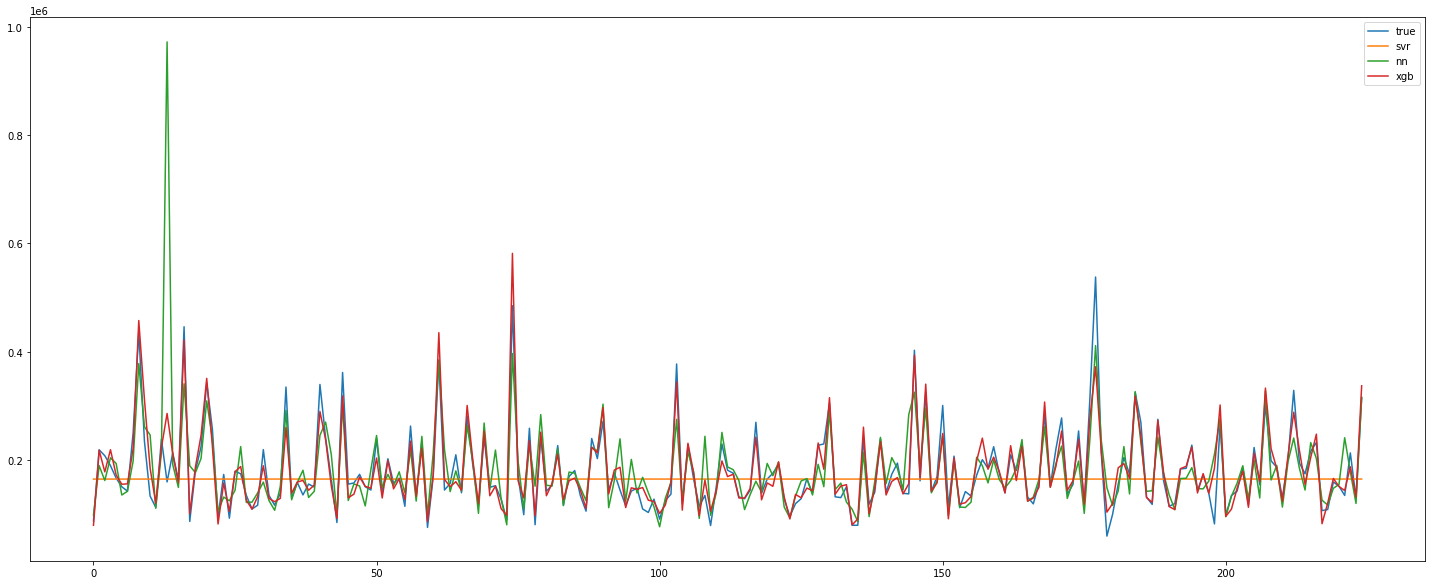

In [9]:
plt.figure(figsize=(25,10))
plt.plot(y_test, label='true')
plt.plot(svr_pred, label='svr')
plt.plot(nn_pred, label='nn')
plt.plot(xbg_pred, label='xgb')
plt.legend()

In [10]:
print(mean_absolute_error(y_test, svr_pred), mean_absolute_error(y_test, xbg_pred), mean_absolute_error(y_test, nn_pred))
print(mean_squared_error(y_test, svr_pred), mean_squared_error(y_test, xbg_pred), mean_squared_error(y_test, nn_pred))

53934.39040398927 16078.581527777778 29837.726215277777
6015975116.898481 649771172.155702 4362883013.66366


In [11]:
ids = test.pop('Id')
preds = xgb.predict(test)


TypeError: write() takes exactly one argument (2 given)

In [18]:

with open('submission.txt', 'w') as file:
    for row in list(zip(ids, preds)):
        file.write(f'{row[0]}, {row[1]:.2f}\n')
